#Bibliotecas


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import keras
from keras import layers
import random

# Definir a seed para garantir reprodutibilidade dos resultados
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

#Dados e constantes

In [ ]:
# Inicializar os conjuntos de treino e teste
dataset = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = dataset.load_data()

A seguir, foram definidas as constantes para a dimensão das imagens (28x28 píxeis) e as labels (10 classes) do dataset Fashion MNIST.

Além disso, foram implementados dois *callbacks* essenciais para o treino do modelo:

*   **BEST_MODEL_CHECKPOINT**: Salva os pesos do modelo sempre que ele tiver o melhor desempenho no conjunto de validação, minimizando a perda de validação (*val_loss*).
*   **EARLY_STOPPING**: Interrompe o treino se a perda de validação não melhorar após 5 epochs consecutivos, evitando *overfitting* e desperdício de recursos.

In [ ]:
# constantes - dimensão das imagens
IMG_HEIGHT = 28
IMG_WIDTH = 28

# constantes - labels/classes e número de classes
LABELS = ["T-Shirt/Top",
          "Trouser",
          "Pullover",
          "Dress",
          "Coat",
          "Sandal",
          "Shirt",
          "Sneaker",
          "Bag",
          "Boot"]
N_CLASSES = 10

# callbacks
BEST_MODEL_CHECKPOINT = keras.callbacks.ModelCheckpoint(
    filepath="tmp/best_model.weights.h5",      # ficheiro para os pesos do "melhor modelo"
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

EARLY_STOPPING = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

#Normalização

A normalização foi feita dividindo os valores dos pixels das imagens por 255, para ficarem no intervalo de 0 a 1, facilitando o treino da rede. As *labels* foram transformadas para o formato *one-hot encoding*, pois a rede precisa que o *output* seja um vetor. Por outro lado, as imagens (*inputs*) não precisam desta conversão, já que a rede neuronal consegue processar os píxeis diretamente.


In [ ]:
# normalização
x_train = x_train / 255.0
x_test = x_test / 255.0

print("Número de amostras no training set original: " + str(x_train.shape[0]))
print("Número de amostras no test set original: " + str(x_test.shape[0]))
print("Não esquecer que se pretende também gerar um validation set!")

# transformar vetor das labels numa matriz - adequado para a classificação
# multiclasse da Parte 1, mas não para a classificação binária da Parte 2
y_train = keras.utils.to_categorical(y_train,N_CLASSES)
y_test = keras.utils.to_categorical(y_test,N_CLASSES)

Número de amostras no training set original: 60000
Número de amostras no test set original: 10000
Não esquecer que se pretende também gerar um validation set!


In [ ]:
# dimensões dos conjuntos de treino e teste (inputs)
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
# dimensões dos conjuntos de treino e teste (outputs)
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

#Visualização

Amostra de 24 imagens do conjunto de treino com suas respectivas classes.

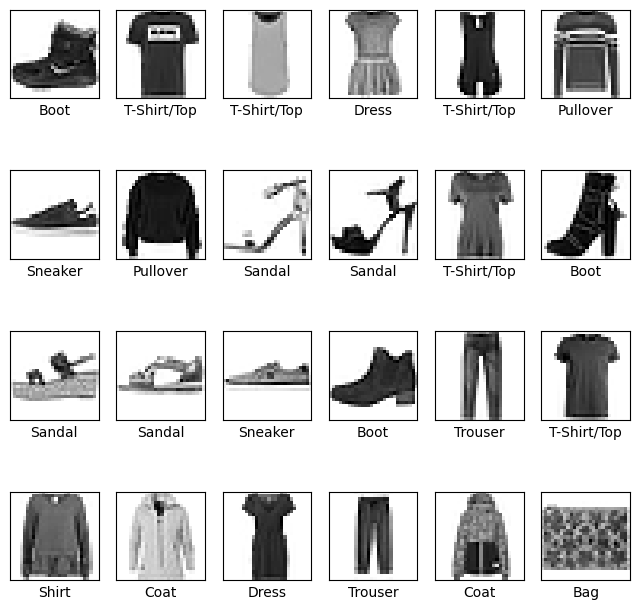

In [ ]:
plt.figure(figsize = (8, 8))

for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
    plt.xlabel(LABELS[np.argmax(y_train[i])])

plt.show()

#Parte 1 – Implementar e avaliar uma rede neuronal para classificação multiclasse

###a) Obtenha um conjunto de validação para monitorizar o treino da rede (divida o conjunto de treino original)

In [ ]:
from sklearn.model_selection import train_test_split

x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

print("Novo conjunto de treino:", x_train2.shape[0])
print("Conjunto de validação:", x_val.shape[0])
print("Conjunto de teste:", x_test.shape[0])

Novo conjunto de treino: 48000
Conjunto de validação: 12000
Conjunto de teste: 10000


###b) Construa um modelo de rede neuronal adequado, que seja capaz de classificar segundo as 10 classes do dataset





A rede neuronal definida possui  uma camada de entrada, duas camadas ocultas (*hidden*) e uma camada de saída:

1.   Camada de Entrada: Foi usada a camada *Flatten* mencionada no enunciado, que converte as imagens 28x28 em vetores unidimensionais para que a rede possa processá-las.
2.   Camadas Ocultas: Utilizamos duas camadas ocultas para conseguir capturar padrões complexos dos dados, e equilibrar a complexidade do modelo evitando o *overfitting*. Ambas as camadas, com 128 e 64 unidades, utilizam a função de ativação ReLU, que é eficiente para acelerar o treino e evitar o  *vanishing gradient problem* (dificuldade na atualização dos pesos das camadas iniciais devido a gradientes extremamente pequenos), garantindo que a rede aprenda de forma mais eficaz.
3.  Camada de Saída: A camada final possui 10 unidades e utiliza a função *Softmax*, que converte as saídas em probabilidades, permitindo à rede determinar a classe mais provável para cada entrada.



In [ ]:
modelo_1 = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape = (28, 28)),

    tf.keras.layers.Dense(128, activation = 'relu'),

    tf.keras.layers.Dense(64, activation = 'relu'),

    tf.keras.layers.Dense(10, activation = 'softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


###c) Compile a rede, escolhendo uma função de perda adequada e um algoritmo de otimização

O método de otimização utilizado foi o Adam, que ajusta dinamicamente a taxa de aprendizagem para melhorar a convergência. A função de perda escolhida foi a *categorical cross-entropy*, adequada para classificação multiclasse, uma vez que calcula a diferença entre as probabilidades previstas e as reais.

In [ ]:
modelo_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005), loss = 'categorical_crossentropy', metrics = ['accuracy'])

###d) Treine o modelo – sugere-se que treine no máximo 50 épocas, e que use callbacks (ver o anexo) – espera-se que atinja uma taxa de acertos na ordem dos 85-90% no conjunto de teste

Para o treino do modelo, foram considerados os 50 épocas mencionadas no enunciado, e utilizados os *callbacks* previamente definidos, garantindo que os melhores pesos fossem guardados e que o treino fosse interrompido caso não houvesse melhoria na perda de validação após 5 épocas consecutivas.

In [ ]:
callbacksprof = [BEST_MODEL_CHECKPOINT, EARLY_STOPPING]
fit_modelo1_treino = modelo_1.fit(x_train2, y_train2, epochs = 50, batch_size = 64,  validation_data=(x_val, y_val), callbacks = callbacksprof, verbose = 1)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7379 - loss: 0.7916 - val_accuracy: 0.8472 - val_loss: 0.4355
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8513 - loss: 0.4202 - val_accuracy: 0.8572 - val_loss: 0.3929
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8659 - loss: 0.3721 - val_accuracy: 0.8668 - val_loss: 0.3682
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8776 - loss: 0.3426 - val_accuracy: 0.8711 - val_loss: 0.3577
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8848 - loss: 0.3204 - val_accuracy: 0.8733 - val_loss: 0.3499
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8918 - loss: 0.3020 - val_accuracy: 0.8774 - val_loss: 0.3423
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8953 - loss: 0.2872 - val_accuracy: 0.8788 - val_loss: 0.3390
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9007 - loss: 0.2738 - val_accuracy: 0.

In [ ]:
# Sumário do modelo treinado:
modelo_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 328,160 (1.25 MB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 218,774 (854.59 KB)

O sumário do modelo descreve a arquitetura da rede neuronal sequencial:
1. Camada de Entrada: transforma as imagens bidimensionais (28x28) num vetor unidimensional com 784 elementos (28 * 28 = 784). Não possui parâmetros treináveis, pois apenas reorganiza os dados.
2. Camada Oculta 1: conectada com 128 neurónios que resultam em 100.480 parâmetros (128 * 784 = 100.480).
3. Camada Oculta 2: conectada com 64 neurónios que resultam em 8.256 parâmetros (128 * 64 = 8.256).
4. Camada de Saída: apresenta 10 neurónios correspondentes às classes do dataset e 650 parâmetros (64 * 10 + 10 = 650).

###e) Produza gráfico(s) que mostre(m) a evolução da perda e dos acertos durante o treino

Criámos dois gráficos para a representação da evolução da perda e dos acertos durante o treino: o gráfico *Training and Validation Accuracy* e gráfico *Training and Validation Loss*. Estes gráficos são essenciais para avaliar se o modelo está a aprender com os dados de treino e como está a generalizar para os dados de validação.

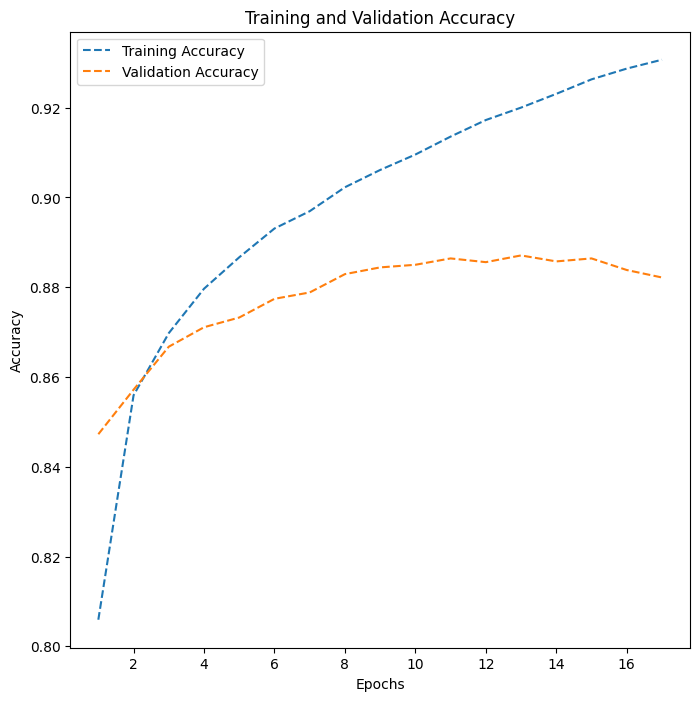

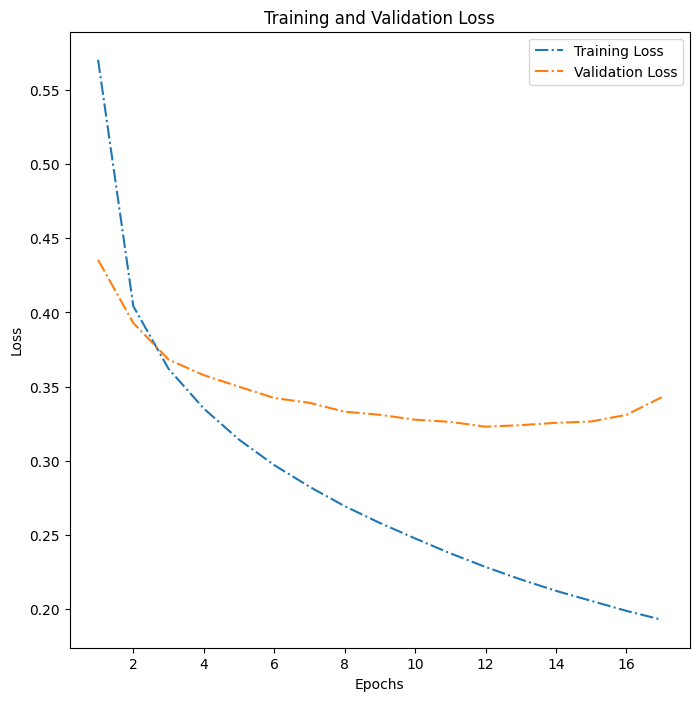

In [ ]:
dict_hist = fit_modelo1_treino.history

epochs = [i for i in range(1, len(dict_hist['accuracy']) + 1)]

plt.figure(figsize=(8, 8))
plt.plot(epochs, dict_hist['accuracy'], ls='--', label='Training Accuracy')
plt.plot(epochs, dict_hist['val_accuracy'], ls='--', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(epochs, dict_hist['loss'], ls='-.', label='Training Loss')
plt.plot(epochs, dict_hist['val_loss'], ls='-.', label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Gráfico Training e Validation Accuracy:**


*   Ambas as linhas mostram uma tendência ascendente nas primeiras épocas, indicando que o modelo está a aprender e a melhorar tanto no treino quanto na validação.
*   A precisão no treino continua a aumentar ao longo das épocas, enquanto a precisão na validação estabiliza por volta da época 10.
*   A diferença crescente entre as duas linhas pode indicar *overfitting*, ou seja, o modelo está a memorizar os dados de treino em vez de generalizar bem para novos dados. Entretanto, a diferença (~4%) entre as duas linhas parece ser pequena para assumirmos o *overfitting*.


**Gráfico Training and Validation Loss:**


*   Uma perda mais baixa no treino (20%) em comparação à validação (35%) é
esperada, pois o modelo tem acesso direto aos dados de treino.
*   A estabilização da perda na validação na época 10 indica que o modelo atingiu um ponto ótimo e não está a sofrer *overfitting* significativo.


A precisão final na validação (~88%) é consistente com os objetivos esperados para este tipo de tarefa.


###f) Calcule e mostre a taxa de acertos no conjunto de teste, após ter treinado o modelo.

Para esta questão, considerámos como "taxa de acertos" as métricas apresentadas juntamente com a matriz de confusão, que também são utilizadas para avaliar o desempenho do modelo. Os resultados são apresentados em conjunto com a questão g).

###g) Mostre uma matriz de confusão e determine e comente quais as classes que a rede confunde mais facilmente umas com as outras.

In [ ]:
# Função para calcular e apresentar métricas de avaliação do modelo
def metrics_score(actual, predicted):

    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = LABELS, yticklabels = LABELS)

    plt.title('Confusion Matrix')

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.96      0.98      0.97      1000
           2       0.78      0.82      0.80      1000
           3       0.84      0.92      0.88      1000
           4       0.85      0.74      0.79      1000
           5       0.99      0.92      0.95      1000
           6       0.73      0.68      0.70      1000
           7       0.93      0.94      0.93      1000
           8       0.96      0.97      0.97      1000
           9       0.91      0.98      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



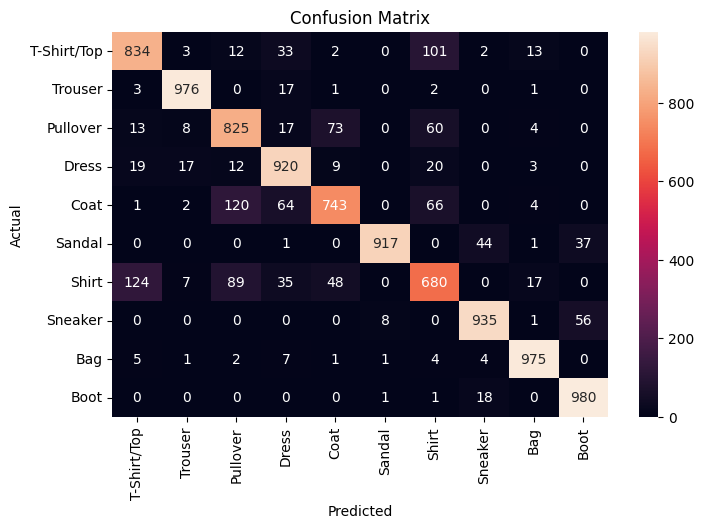

In [ ]:
prev_m1 = np.argmax(modelo_1.predict(x_test), axis  = -1)

# Convert y_test to multiclass format by selecting the class with the highest probability
y_test_multiclass = np.argmax(y_test, axis=1)

# Métricas e matriz de confusão para o conjunto de teste
metrics_score(y_test_multiclass, prev_m1)

**Classes com maior confusão:**
1. Classe Shirt - apresenta uma taxa de *recall* de apenas 68%, indicando que o modelo frequentemente classifica imagens desta classe como outras classes, como T-Shirt/Top, Pullover e Coat.
2. Classe Coat - o *recall* é de 74%, sugerindo que o modelo também tem dificuldade em distinguir esta classe de outras, como Pullover, Shirt e Dress.
3. Classe Pullover - embora tenha um *recall* relativamente alto (82%), também apresenta confusão significativa com as classes Coat e Shirt.

Erros comuns incluem confusões com as classes que possuem **características visuais semelhantes**.

De forma a verificar a presença de *overfitting*, procedemos também à análise das métricas e da matriz de confusão para os conjuntos de treino e validação:

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Métricas para o conjunto de treino:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4798
           1       0.98      0.99      0.99      4781
           2       0.86      0.87      0.87      4795
           3       0.89      0.97      0.93      4816
           4       0.89      0.81      0.85      4798
           5       1.00      0.96      0.98      4789
           6       0.83      0.79      0.81      4782
           7       0.96      0.95      0.96      4841
           8       0.98      0.99      0.99      4803
           9       0.94      0.99      0.97      4797

    accuracy                           0.92     48000
   macro avg       0.92      0.92      0.92     48000
weighted avg       0.92      0.92      0.92     48000



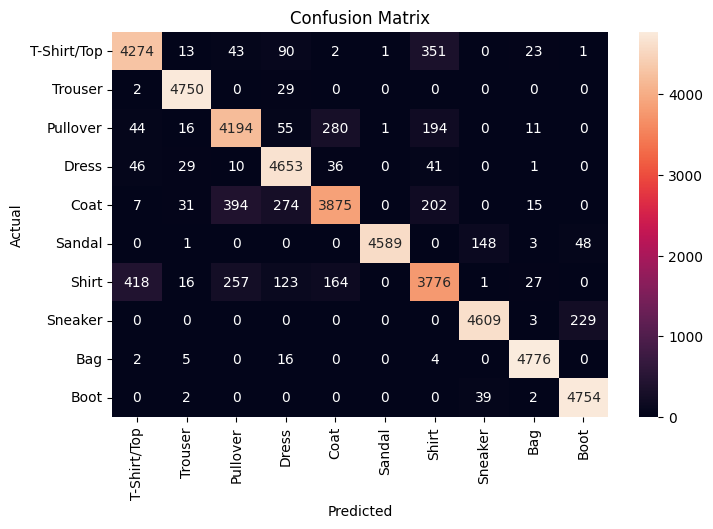

In [ ]:
# Predições para o conjunto de treino
train_preds_probs = modelo_1.predict(x_train2)
train_preds_labels = np.argmax(train_preds_probs, axis=1)

print("Métricas para o conjunto de treino:")
metrics_score(np.argmax(y_train2, axis=1), train_preds_labels)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Métricas para o conjunto de validação:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1202
           1       0.97      0.98      0.98      1219
           2       0.80      0.83      0.81      1205
           3       0.84      0.94      0.88      1184
           4       0.86      0.76      0.81      1202
           5       0.98      0.92      0.95      1211
           6       0.75      0.69      0.72      1218
           7       0.92      0.92      0.92      1159
           8       0.96      0.97      0.96      1197
           9       0.91      0.97      0.94      1203

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000



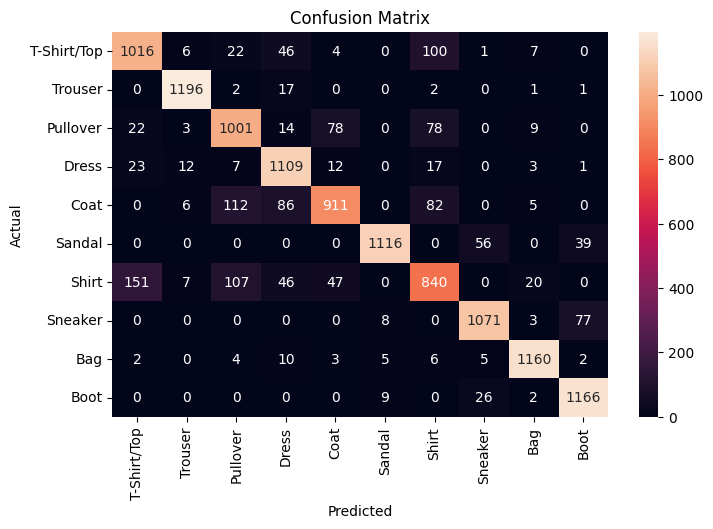

In [ ]:
# Predições para o conjunto de validação
val_preds_probs = modelo_1.predict(x_val)
val_preds_labels = np.argmax(val_preds_probs, axis=1)

print("Métricas para o conjunto de validação:")
metrics_score(np.argmax(y_val, axis=1), val_preds_labels)

Após a análise das matrizes de confusão dos conjuntos de treino e de validação, observámos que as classes que são mais confundidas com as outras pela rede mantêm-se as mesmas, com pequenas variações percentuais no *recall*. Deste modo, descartamos a hipótese de *overfitting* e podemos concluir que o modelo conseguiu generalizar bem os dados no conjunto de treino.

#Parte 3 – Questão

Para responder à questão proposta, foi necessário adaptar o Modelo 1 (originalmente treinado para classificação multiclasse) para uma tarefa binária. Para isso, as predições do modelo foram transformadas numa classificação binária através da função mapping_label(), que atribui o valor 1 ao vestuário e 0 ao calçado/malas.
Após a conversão, compararam-se as predições binárias com os rótulos reais e calcularam-se as métricas de avaliação através da matriz de confusão.
Finalmente, foram comparados ambos modelos.

In [ ]:
# Obter as predições do Modelo 1 e convertê-las para classes binárias
prev_probs1 = modelo_1.predict(x_test)
prev_classes1 = np.argmax(prev_probs1, axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Função para converter classes multiclasse em binárias (1 para vestuário, 0 para calçado/malas)
def mapping_label(classe):
    if classe in [0, 1, 2, 3, 4, 6]:
        return 1
    else:
        return 0

In [ ]:
# Converter as previsões do modelo para obter um vetor de predições binárias
prev_binary = np.array([mapping_label(c) for c in prev_classes1])

In [ ]:
# Converter os rótulos reais one-hot para inteiros e binarizá-los
y_test_int = np.argmax(y_test, axis=1)
y_test_binary = np.array([mapping_label(c) for c in y_test_int])

               precision    recall  f1-score   support

    Vestuário       0.99      0.99      0.99      4000
Calçado/Malas       1.00      0.99      0.99      6000

     accuracy                           0.99     10000
    macro avg       0.99      0.99      0.99     10000
 weighted avg       0.99      0.99      0.99     10000



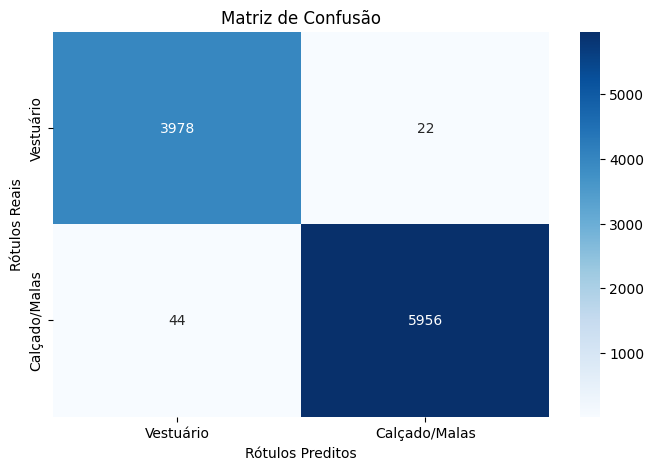

In [ ]:
# Função para calcular e apresentar métricas de avaliação do modelo
def metrics_score(actual, predicted):
    target_names = ["Vestuário", "Calçado/Malas"]
    print(classification_report(actual, predicted, target_names=target_names))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues",
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Matriz de Confusão')
    plt.ylabel('Rótulos Reais')
    plt.xlabel('Rótulos Preditos')
    plt.show()

metrics_score(y_test_binary, prev_binary)

**Classe 0 (Calçado e Malas):**

*   A precisão é de 99%, o que significa que das predições que o modelo fez como sendo da classe 0, 99% estavam corretas.
*   O *recall* também é de 99%, indicando que o modelo conseguiu identificar corretamente quase todos os exemplos reais desta classe.

**Classe 1 (Vestuário):**

*   A precisão é de 100%, ou seja, todas as predições feitas como sendo da classe 1 estavam corretas.
*   O *recall* é de 99%, o que significa que o modelo deixou de identificar apenas uma pequena fração dos exemplos reais desta classe.

Não há evidências significativas de confusões entre as classes, indicando que o modelo é altamente eficaz para esta tarefa binária.

Para comparar ambos os modelos (multiclasse e binário), os resultados da rede treinada diretamente para a classificação binária, implementada na Parte 2, são apresentados a seguir:

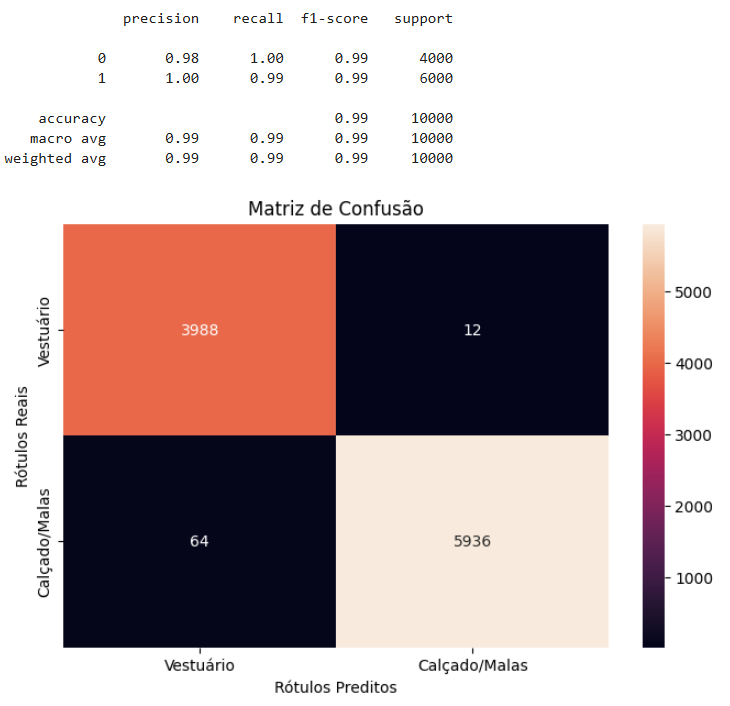

Após comparar a matriz de confusão dos modelos com classificação multiclasse e binária, verificou-se que as diferenças nos falsos positivos e falsos negativos são mínimas, apresentando ligeiras variações  pouco significativas tendo em conta o número total de observações. Além disso, as métricas de *precision*  e *recall* mantiveram-se consistentemente elevadas, com valores entre 98% e 100%.

Assim, podemos concluir:


*   Ambas as abordagens apresentaram métricas de precisão e recall consideravelmente altas (0,98 a 1). Ambos os modelos multiclasse com binarização e o modelo binário direto tiveram um bom desempenho, sendo semelhantes também.
*   Modelos mais simples, com menos camadas, podem produzir resultados tão bons quanto modelos mais complexos. Muitas vezes, o desempenho do modelo depende mais da qualidade dos dados do que da complexidade do modelo (Géron, 2019).




#Referências

Géron, A. (2019). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. O'Reilly Media.*